In [2]:
import numpy as np
np.bool = np.bool_
import copy as cp
import sys
import matplotlib as mt
import matplotlib.pyplot as plt
import pickle as pkl
import sklearn as skl
from sklearn.ensemble import RandomForestClassifier as rfc, RandomForestRegressor as rfr
from sklearn.model_selection import train_test_split as splt
from sklearn.metrics import accuracy_score as acc, confusion_matrix as cfm
import sklearn.metrics as mtr
import scipy as sc
import scipy.cluster as scc
from tqdm import tqdm
import time
import pyemma
import pyemma.coordinates as coor
import pyemma.plots as mplt

In [ ]:
sys.path.append('0_python_modules/')

In [ ]:
import proximity_matrix as pmt
import synthetic_data as syn
import extras
from navjeet_hist import hist_raw_data
import navjeet_hist as nh

## Data

In [3]:
features = np.load('1_datasets/features.npy')
randoms = np.loadtxt('1_datasets/randoms.txt', dtype=int)

In [ ]:
traj_data = [np.load(f'1_datasets/features_{i}.npy') for i in range(6)]
dists = np.loadtxt(f'1_datasets/distances0.xvg', comments=['@','#'], usecols=[3])

## Traditional Approach

In [ ]:
tic2 = coor.tica(traj_data, lag=700, dim=2).get_output()[0]

(<Figure size 576x432 with 2 Axes>, <AxesSubplot:>)

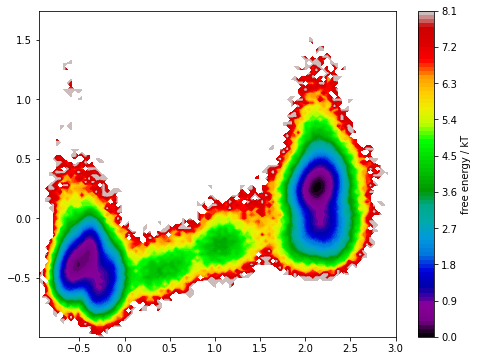

In [17]:
fig,ax = plt.subplots(1,figsize=(8,6))
mplt.plot_free_energy(tic2[:,0], tic2[:,1], ax=ax)

In [ ]:
fes = nh.hist_range(tic2, dists, mini=0, maxi=0.6 )

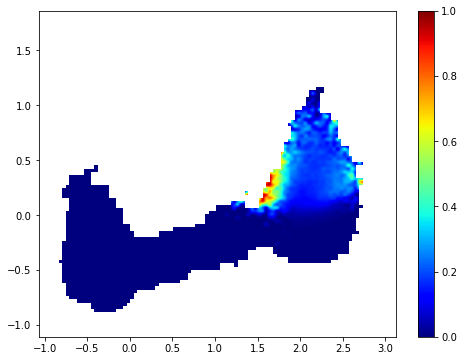

In [22]:
fig,ax = plt.subplots(1,figsize=(8,6))
cb=ax.imshow(fes[4].T, extent=fes[:4], origin='lower', aspect='auto', interpolation='gaussian', cmap='jet', vmin=0, vmax=1)
plt.colorbar(cb)

## Supervised-RF Approach

In [ ]:
labels = np.zeros_like(np.copy(dists))
labels[np.where(dists > 0.6)[0]] = 1
labels = labels.astype(int)

In [ ]:
clfs = []
accu_supervised = np.zeros((len(randoms),2))

for i in range(len(randoms)):
    
        xtrain, xtest, ytrain, ytest = splt(features, labels, test_size=0.3, random_state=randoms[i])
        clf_ = rfc(n_estimators=1000, random_state=randoms[i], n_jobs=94)
        clf_.fit(xtrain, ytrain)

        pred_ = clf_.predict(xtest)
        accu_supervised[i,0] = acc(ytest,pred_)
        accu_supervised[i,1] = extras.get_f1_score( cfm(ytest, pred_) )

        clfs.append(clf_)        

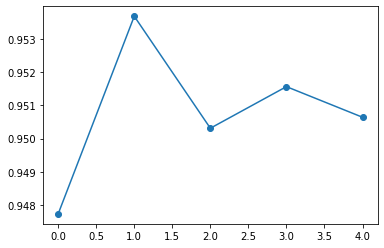

In [25]:
plt.plot(accu_supervised[:,1], '-o')

In [ ]:
fimp_supervised = [
    i.feature_importances_ for i in clfs
]

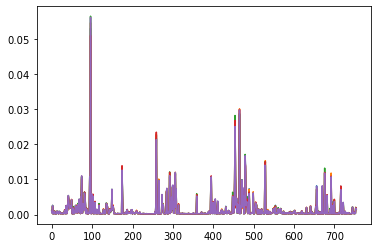

In [27]:
for i in fimp_supervised:
    plt.plot(i)

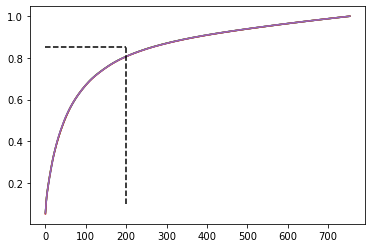

In [30]:
for i in fimp_supervised:
    i = np.cumsum(i[i.argsort()[::-1]])
    plt.plot(i)
plt.plot([200,200],[0.1,0.85], '--', color='black')
plt.plot([0,200],[0.85,0.85], '--', color='black')
plt.show()

In [ ]:
top200_features = fimp_supervised[0].argsort()[::-1][:200]
top200_features = [i[:,top200_features] for i in traj_data]

In [ ]:
tic2 = coor.tica(top200_features, lag=700, dim=2).get_output()[0]
fes = nh.hist_range(tic2, dists, mini=0, maxi=0.6 )

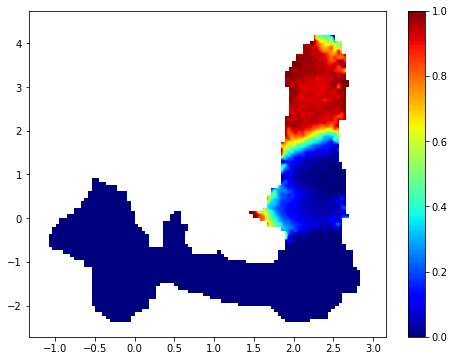

In [32]:
fig,ax = plt.subplots(1,figsize=(8,6))
cb=ax.imshow(fes[4].T, extent=fes[:4], origin='lower', aspect='auto', interpolation='gaussian', cmap='jet', vmin=0, vmax=1)
plt.colorbar(cb)

## Unsupervised-RF

In [ ]:
create_permute = syn.synthetic_data(features, size=1)
create_permute.permute()
pfeatures, plabels = create_permute.get_output()

In [ ]:
clfs = []
accu_permute = np.zeros((len(randoms),2))
for i in range(len(randoms)):
    xtrain, xtest, ytrain, ytest = splt(pfeatures, plabels, test_size=0.3, random_state=randoms[i])
    clf_ = rfc(n_estimators=1000, random_state=randoms[i], n_jobs=94)
    clf_.fit(xtrain, ytrain)

    pred_ = clf_.predict(xtest)
    accu_permute[i,0] = acc(ytest,pred_)
    accu_permute[i,1] = extras.get_f1_score( cfm(ytest, pred_) )


    xtrain, xtest, ytrain, ytest = 0, 0, 0, 0
    clfs.append(clf_)

In [ ]:
permute_pmt = pmt.calculate_condenced_pmt_multi( clfs, features, n_jobs=94 )

In [ ]:
hc_permute = scc.hierarchy.linkage(permute_pmt, method='average')
hlabels_ = extras.get_hc_dtraj(hc_permute, nids=2)

In [ ]:
accu_hc = np.zeros((len(randoms),2))
fes = []

for i in range(len(randoms)):
    
        xtrain, xtest, ytrain, ytest = splt(features, hlabels_, test_size=0.3, random_state=randoms[i])
        clf_ = rfc(n_estimators=1000, random_state=randoms[i], n_jobs=94)
        clf_.fit(xtrain, ytrain)

        pred_ = clf_.predict(xtest)
        accu_hc[i,0] = acc(ytest,pred_)
        accu_hc[i,1] = extras.get_f1_score( cfm(ytest, pred_) )

        xtrain, xtest, ytrain, ytest = 0, 0, 0, 0
        fimp = clf_.feature_importances_

        top200 = fimp.argsort()[::-1][:200]
        tic2 = [traj_data[i][:,top200] for i in range(6)]
        tic2 = coor.tica(tic2, lag=700, dim=2).get_output()[0]
        
        surface = nh.hist_range(tic2, dists, mini=0, maxi=0.6 )
        fes.append(surface)
        

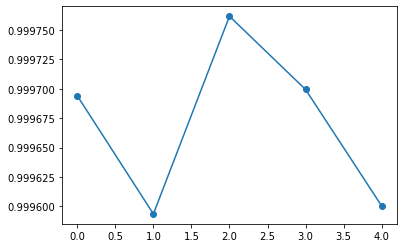

In [39]:
plt.plot(accu_hc[:,1], '-o')
plt.show()

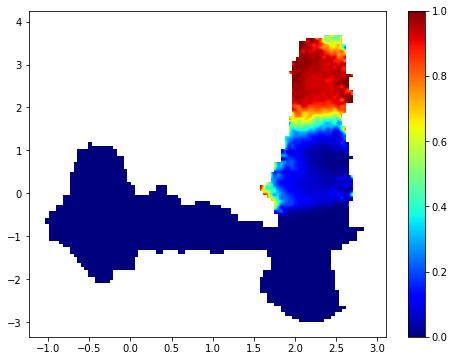

In [34]:
fig,ax = plt.subplots(1,figsize=(8,6))
cb=ax.imshow(fes[0][4].T, extent=fes[0][:4], origin='lower', aspect='auto', interpolation='gaussian', cmap='jet', vmin=0, vmax=1)
plt.colorbar(cb)
plt.show()